# Exploration of the Relationship Between Self-Reported Sleep Habits and Mental Health

### Katherine Wang

## Abstract

Sleeping problems are a prevalent issue that may be tied to cardiovascular and other adverse health problems. This project aims to identify how sleep habits and sleep outcomes may affect one’s mental health. In particular, we are looking at how self-reported quality and length of sleep affect participants’ mental well-being, as captured by the scoring from the RAND 36-Item Short Form Survey (SF-36) questionnaire. The data used for this project comes from the Sleep Heart Health Study (SHHS), a multi-center cohort study that was formed to study the adverse effects of sleep-disordered breathing. 6,441 participants were enrolled in the study between November 1, 1995 and January 31, 1998 [1,2,3,4]. Regression methods such as linear regression, random forest regression, and XGBoost were used to model individuals' SF-36 Mental Health Index Standardized Score. These methods were also used to determine particular sleep habits that were more influential in determining one's Mental Health Index. Associated behaviors such as drinking and caffeine intake were included in the model to adjust for confounders, but our models picked up on that and the number of naps taken per week as the most influential predictors for mental health. This provides a good starting point for future analyses and tells us that future projects should adjust for these predictors to find other influential sleep habits (if there are any). 

## 1. Introduction

Sleep problems, or perceptions of sleep problems, can often affect daily life and mental health. Conversely, the Mayo Clinic identifies symptoms of mental illness to include "significant tiredness, low energy or problems sleeping" as well as alcohol and drug abuse [7]. However, mental health is a hard thing to quantify, much less study associations or causations. This project attempts to study the relationship between self-reported sleep habits and mental health as an indicator of quality of life. 

The data used in this project is from the follow-up visit of the Sleep Heart Health Study (SHHS). The SHHS is a multi-center cohort study that was formed to study the adverse effects of sleep-related breathing [1,2,3,4]. 5,804 participants were originally enrolled in the study and had a baseline visit between November 1, 1995 and January 31, 1998 [1,2,3,4]. Of those 6,441 participants, data from 4,080 participants were used in this project. The questionnaires collected from participants’ second (follow-up) visit were the main source of the self-reported data used in this project.

## 2. Methods

For this analysis, I used the SHHS Visit 2 data for ease of use. The SHHS Visit 2 cohort (n=4080), while smaller than SHHS Visit 1, had more standardized variables. This data was collected between January 2001 and June 2003.

### 2.1 Variable Selection

Since we are looking at the self-reported quality of life and sleep habits, those can all be found under the relevant Questionnaires folder in the data dictionary. This was used to create a subset of the columns that may be relevant.

In [41]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
import matplotlib.pyplot as plt
%matplotlib inline

In [42]:
dat2 = pd.read_csv('shhs2-dataset-0.13.0.csv', encoding = "ISO-8859-1",na_values='nan')
print('# unique patients:',dat2.nsrrid.nunique(),'; # rows in df:',dat2.shape[0])
# convert column names to all lowercase for consistency
dat2.columns = dat2.columns.str.lower() 
# take only people with both qol and sleep habits questionnaire
dat2 = dat2.loc[(dat2.shhs2_ql==1) & (dat2.shhs2_sh==1),:]

# subset columns as identified by folder from the data dictionary
data_dictionary = pd.read_csv('shhs-data-dictionary-0.13.1-variables.csv')
datadict_sub= data_dictionary[data_dictionary.folder.str.\
                              contains('SF-36|Epworth|Quality Of Life|Sleep Habits|FOSQ|SAQLI', flags = re.IGNORECASE)]
print(datadict_sub.folder.unique())

mycols_shhs2 = [col for col in dat2.columns.values if col in datadict_sub.id.values]
print('\n',len(mycols_shhs2), 'columns from shhs2')

shhs2 = dat2.loc[:,mycols_shhs2]
print('shhs2 df shape:',shhs2.shape)

# unique patients: 4080 ; # rows in df: 4080
['Questionnaires/SHHS1/Epworth Sleepiness Scale'
 'Questionnaires/SHHS1/Quality Of Life' 'Questionnaires/SHHS1/SF-36'
 'Questionnaires/SHHS1/Sleep Habits'
 'Questionnaires/SHHS2/Epworth Sleepiness Scale'
 'Questionnaires/SHHS2/FOSQ' 'Questionnaires/SHHS2/Quality Of Life'
 'Questionnaires/SHHS2/SAQLI' 'Questionnaires/SHHS2/SF-36'
 'Questionnaires/SHHS2/Sleep Habits']

 118 columns from shhs2
shhs2 df shape: (3516, 118)


In [43]:
# shhs2.describe()
# % missing
missing = shhs2.isnull().sum()/shhs2.shape[0]
# which ones are >50% missing?
missing[missing > 0.5]

lengpmnap    0.613766
sh315        0.870307
sh321        0.505119
sh322        0.503129
sh323        0.501138
sh324        0.505973
sh307a       0.922071
sh307b       0.960751
sh307c       0.764790
sh307d       0.894198
sh318a       0.987770
sh318b       0.985779
sh318c       0.997440
sh318d       0.992605
sh322a       0.683447
sh323a       0.576792
saqli        0.661832
fosq         0.663254
dtype: float64

After some very brief exploratory analysis, I then focused on selecting columns that would represent quality of life and sleep habits. 

#### 2.1.1 Epworth Sleepiness Scale

The Epworth Sleepiness Scale is a well-known method of objectively quantifying daytime sleepiness in adults. It is measured by having individuals complete a self-administered questionnaire and is then scored by summing the responses of the 8 questions in the questionnaire [5]. In my analysis, I only included the ESS summary score.

In [57]:
# select subset of columns to use
dd_shhs2 = datadict_sub.loc[datadict_sub.folder.str.contains('shhs2', flags=re.IGNORECASE),:]
## keep only ESS score from the ESS variables
mycols = ['ess_s2']

#### 2.1.2 Quality of Life Measures

There were two sets of variables that captured information regarding individuals' quality of life: those from the quality of life questionnaire and those from the 36-Item Short Form Survey (SF-36) questionnaire. I ended up using the SF-36 questions because they were standardized and easier to use for prediction purposes.

The SF-36 questionnaire is also a widely-accepted method of capturing an individual's quality of life. Like the ESS, the SF-36 also has a method of scoring and summarizing the responses. The scoring method includes a way of recoding the responses such that the direction (i.e. positive or negative) of the responses are standardized [6].

Because of these benefits, I only considered the standardized scores as quality of life measurements in this analysis.

In [58]:
qol = dd_shhs2.loc[dd_shhs2.folder.str.contains('quality of life', flags=re.IGNORECASE),'id'].values[1:]
print('quality of life columns:')
print(shhs2[qol].isnull().sum()/shhs2[qol].shape[0])

quality of life columns:
ql201     0.001138
ql202     0.000853
ql203a    0.009670
ql203b    0.005119
ql203c    0.002844
ql203d    0.004266
ql203e    0.005688
ql203f    0.003697
ql203g    0.004835
ql203h    0.004551
ql203i    0.006257
ql203j    0.002560
ql204a    0.003982
ql204b    0.003697
ql204c    0.003413
ql204d    0.003697
ql205a    0.006257
ql205b    0.006257
ql205c    0.006257
ql206     0.003982
ql207     0.003697
ql208     0.004551
ql209a    0.003129
ql209b    0.003413
ql209c    0.003129
ql209d    0.002560
ql209e    0.002560
ql209f    0.004266
ql209g    0.003982
ql209h    0.002275
ql209i    0.002560
ql210     0.007110
ql211a    0.004835
ql211b    0.004551
ql211c    0.004551
ql211d    0.004266
dtype: float64


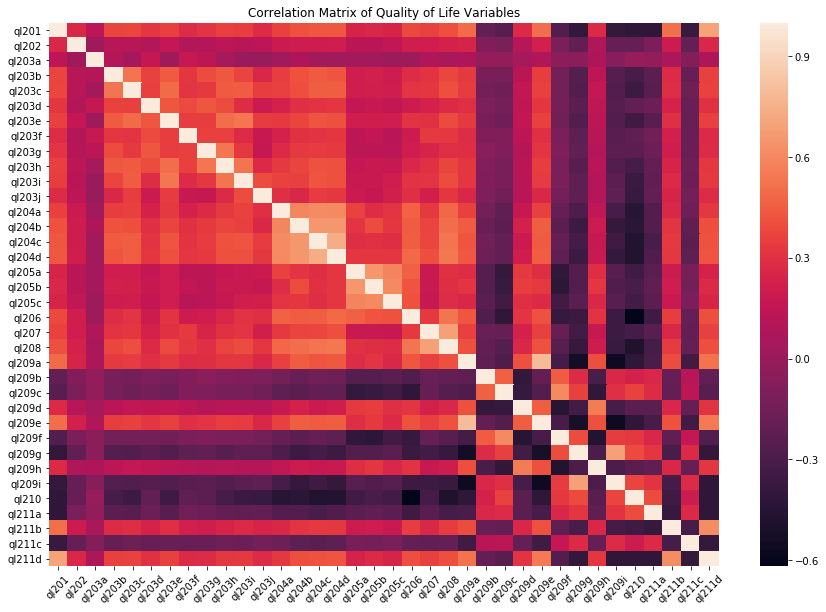

In [59]:
# quick look at correlations
corr = shhs2[qol].corr()
fig, ax = plt.subplots(figsize=(15,10))    
sns.heatmap(corr, ax = ax)
_ = ax.set_xticklabels(corr.columns.values,rotation=45)
_ = ax.set_yticklabels(corr.columns.values,rotation=0)
_ = ax.set_title('Correlation Matrix of Quality of Life Variables')

In [60]:
# don't use any qol, use sf36 instead
# sf36
sf36 = dd_shhs2.loc[dd_shhs2.folder.str.contains('sf-36', flags=re.IGNORECASE),'id'].values
print('sf-36 columns:')
print(shhs2[sf36].isnull().sum()/shhs2[sf36].shape[0])

sf-36 columns:
bp_s2       0.006257
gh_s2       0.004551
mcs_s2      0.013652
mh_s2       0.002560
pcs_s2      0.013652
pf_s2       0.011661
rawbp_s2    0.003697
rawgh_s2    0.003697
rawmh_s2    0.002275
rawpf_s2    0.002560
rawre_s2    0.006542
rawrp_s2    0.003129
rawsf_s2    0.000853
rawvt_s2    0.002275
re_s2       0.075370
rp_s2       0.003129
sf_s2       0.002275
vt_s2       0.006826
dtype: float64


In [61]:
# use standardized instead of raw - standardized takes directional measures into account
rawcols = [i.startswith('raw') for i in sf36.tolist()]
my_sf36 = set(sf36) - set(sf36[rawcols])
mycols.extend(list(my_sf36))

#### 2.1.3 Measures of Sleep Habits

Self-reported sleep habits were captured in the Sleep Habits Questionnaire. I looked at each question individually to see if the features were relevant or if the feature needed to be rescaled. In some cases, I did not use certain questions because there was too much missing data (over 90% missing for some). I also rescaled the variables in some instances so that the responses were standardized with 0 representing 'nothing', 'never', or similar. 

In [62]:
# sleep habits
sh = dd_shhs2.loc[dd_shhs2.folder.str.contains('sleep habits', flags=re.IGNORECASE),'id'].values
print('sleep habits columns:')
print(shhs2[sh].isnull().sum()/shhs2[sh].shape[0])

sleep habits columns:
formdate_sh      0.000000
lengpmnap        0.613766
sh304            0.006826
sh304a           0.364619
sh305            0.362059
sh307a           0.922071
sh307b           0.960751
sh307c           0.764790
sh307d           0.894198
sh308a           0.002275
sh308b           0.002560
sh308c           0.003413
sh308d           0.004551
sh308e           0.002844
sh308f           0.005973
sh308g           0.003129
sh308h           0.003413
sh308i           0.005404
sh308j           0.003697
sh309            0.001991
sh310            0.220705
sh311            0.242605
sh312            0.245734
sh313            0.220705
sh314            0.005404
sh315            0.870307
sh316            0.007679
sh317            0.004266
sh318a           0.987770
sh318b           0.985779
sh318c           0.997440
sh318d           0.992605
sh320            0.003982
sh321            0.505119
sh322            0.503129
sh322a           0.683447
sh323            0.501138
sh323a          

In [63]:
# if sh304 = 1, then there is a value 
# for sh304a
shhs2[['sh304','sh304a']].describe()

,sh304,sh304a
count,3492.000000,2234.000000
mean,0.644330,4.978962
std,0.478784,4.026113
min,0.000000,0.000000
25%,0.000000,3.000000
50%,1.000000,4.000000
75%,1.000000,7.000000
max,1.000000,56.000000


In [64]:
# so create a new column with combined info
shhs2['sh304_new'] = shhs2['sh304a']
shhs2.loc[shhs2.sh304 == 0,'sh304_new'] = 0
# add this to the list of columns to be kept
mycols.extend(['sh304_new','sh305'])

None of the `sh307` features were used. This is because the responses had a very high rate of missing responses, rendering the information unhelpful. Also, this question asked about the individuals' "reasons for regular napping in the afternoon" was a follow-up to the previous questions. This analysis is not looking at causal inference, so I assumed the important information was captured in the previous questions and removing these questions wouldn't change the results significantly. 

The `sh308` columns captured frequency of experiencing certain sleep disruptions at night and tiredness. They were captured on a scale from 1-5 with 1 being 'never', so I rescaled the values to start at 0 being 'never'.

In [65]:
# range from 1-5 with 1 being never, so rescale such that never = 0
cols308 = [i for i in sh if i.startswith('sh308')]

for col in cols308:
    shhs2[col] = shhs2[col] - 1
    
mycols.extend(cols308)

* `sh315` wasn't included either because 87% of the data was missing and it was a follow up question to `sh314`.
* `sh316` was rescaled to start at 0
* the questions related to whether a doctor has diagnosed their sleep-related disorder were discarded because of extremely high rates of missingness.
* only the following smoking and drinking related habits were kept:
    - "Have you smoked as many as 20 packs of cigarettes in your whole lifetime?"
    - "Are you currently still smoking?"
    - "On average, during the entire time you smoked, how many cigarettes did you usually smoke per day?"
    - "On a typical day, how many cups of regular coffee (with caffeine) do you drink?"
    - "How many cups of regular tea (with caffeine) do you drink on a typical day?"
    - "How many glasses or cans of cola or other soda with caffeine do you drink on a typical day? _________ glasses"
    - "How many glasses or cans of cola or other soda with caffeine do you drink on a typical day? _________ cans"
    - "How many glasses (4 oz.) of wine do you usually have per week?"
    - "How many bottles or cans of beer (12 oz.) do you usually have per week?"
    - "How many drinks with hard liquor (1 shot) do you usually have per week?"

In [66]:
shhs2['sh316'] = shhs2['sh316'] - 1
mycols.extend(['sh309','sh310','sh311','sh312','sh313','sh314','sh316','sh320','sh323',
               'sh324','sh325','sh326','sh327a','sh327b','sh328','sh329','sh330'])

In [67]:
mycols.extend(['totminfallslp','totminslpwd','totminslpwe'])

In [68]:
# final dataframe
df = shhs2[mycols]
print('df shape: ',df.shape)
df.sample(3)

df shape:  (3516, 43)


,ess_s2,pcs_s2,bp_s2,pf_s2,gh_s2,vt_s2,rp_s2,mcs_s2,mh_s2,re_s2,...,sh325,sh326,sh327a,sh327b,sh328,sh329,sh330,totminfallslp,totminslpwd,totminslpwe
9,9.0,57.184186,84.0,100.000000,92.0,65.0,100.0,52.439685,76.0,100.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,5.0,480.0,480.0
2770,4.0,52.645883,84.0,83.333333,82.0,85.0,100.0,57.526041,80.0,100.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,480.0,570.0
585,6.0,57.572806,100.0,100.000000,80.0,80.0,100.0,54.642652,80.0,100.0,...,0.0,4.0,1.0,0.0,0.0,0.0,0.0,20.0,390.0,480.0


In [69]:
print('% missing:')
df.isnull().sum()/df.shape[0]

% missing:


ess_s2           0.017349
pcs_s2           0.013652
bp_s2            0.006257
pf_s2            0.011661
gh_s2            0.004551
vt_s2            0.006826
rp_s2            0.003129
mcs_s2           0.013652
mh_s2            0.002560
re_s2            0.075370
sf_s2            0.002275
sh304_new        0.011377
sh305            0.362059
sh308a           0.002275
sh308b           0.002560
sh308c           0.003413
sh308d           0.004551
sh308e           0.002844
sh308f           0.005973
sh308g           0.003129
sh308h           0.003413
sh308i           0.005404
sh308j           0.003697
sh309            0.001991
sh310            0.220705
sh311            0.242605
sh312            0.245734
sh313            0.220705
sh314            0.005404
sh316            0.007679
sh320            0.003982
sh323            0.501138
sh324            0.505973
sh325            0.002844
sh326            0.002275
sh327a           0.008817
sh327b           0.007679
sh328            0.002844
sh329       

### 2.2 Visualize the data

From the distribution plot below, we can see that most of the people in the SHHS2 cohort have pretty good mental health outcomes.

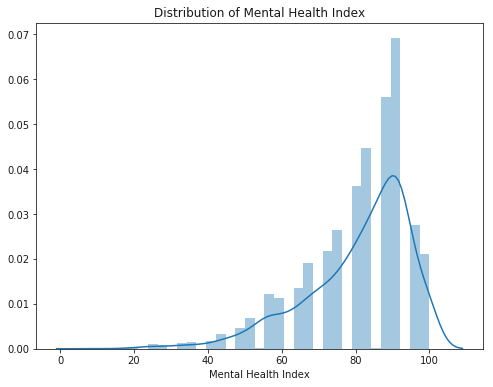

In [358]:
plt.figure(figsize=(8,6))
sns.distplot(df.mh_s2.dropna())
_=plt.title('Distribution of Mental Health Index')
_=plt.xlabel('Mental Health Index')

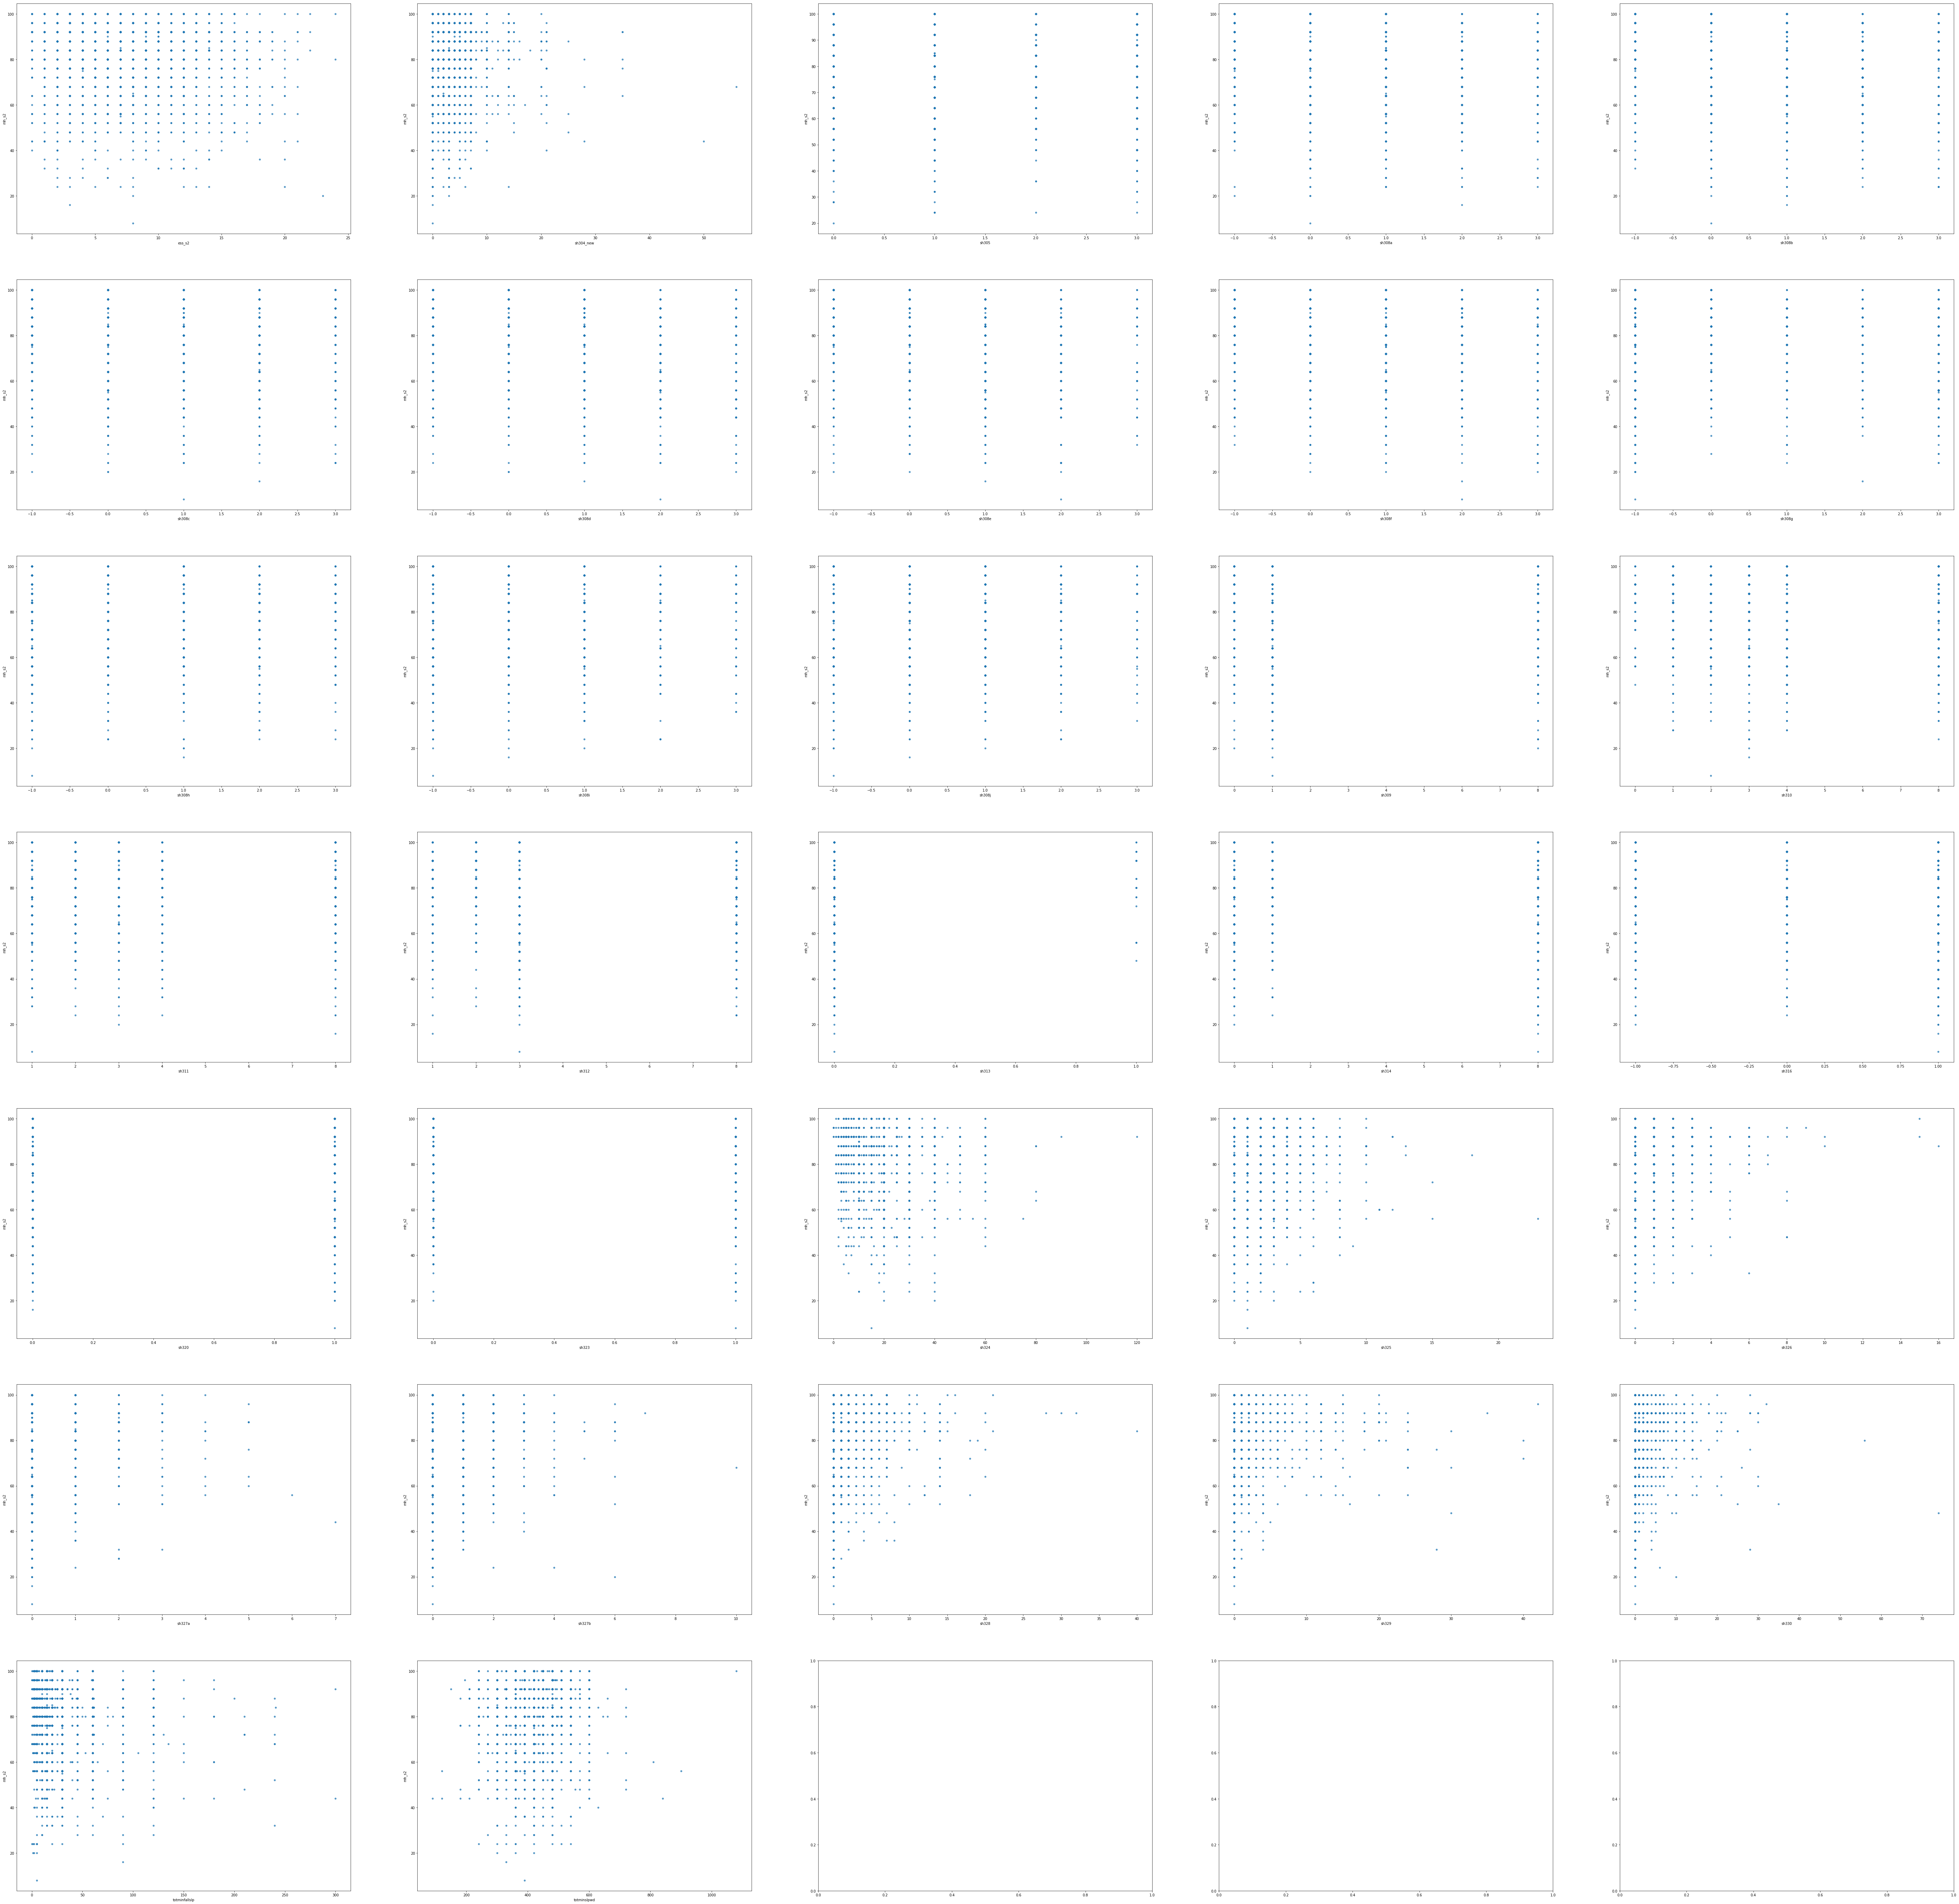

In [70]:
# comparison of each of the input variables vs mental health index
sleep_vars = df.loc[:,['ess_s2','sh304_new', 'sh305', 'sh308a','sh308b', 'sh308c', 
                       'sh308d', 'sh308e', 'sh308f', 'sh308g', 'sh308h', 'sh308i', 
                       'sh308j', 'sh309', 'sh310', 'sh311', 'sh312', 'sh313',
                       'sh314', 'sh316', 'sh320','sh323','sh324','sh325','sh326','sh327a',
                       'sh327b','sh328','sh329','sh330','totminfallslp', 'totminslpwd']]
collist = sleep_vars.columns.tolist()
# mental health index standardized score
fig1, axes1 = plt.subplots(nrows=7, ncols=5, figsize=(100,100))

for ax, xcol in enumerate(collist):
    df.plot(kind='scatter', x=xcol, y='mh_s2', ax=axes1[ax//5,ax%5], alpha=0.7)

In [362]:
print('shape of final df used for analysis:',sleep_vars.shape)

shape of final df used for analysis: (3516, 32)


### 2.3 Analysis

The SF-36 questionnaire captured the following standardized scores:

* Pain Index Standardized Score
* General Health Perceptions Standardized Score
* Mental Component Scale Standardized Score
* Mental Health Index Standardized Score
* Physical Component Scale Standardized Score
* Physical Functioning Standardized Score
* Role-Emotional Standardized Score
* Role-Physical Standardized Score
* Social Functioning Standardized Score
* Vitality Standardized Score

Due to the large number of quality of life outcomes that could be studied here, I narrowed the scope to look at one: Mental Health Index Standardized Score (`mh_s2`). Multiple modeling techniques were used to identify the relationship between reported sleep habits and mental health. 

The regression, random forest, and XGBoost were modeled using 90% of the dataset, leaving 10% to test predictions and evaluate model performance.

#### 2.3.1 PCA

PCA was performed on the two sets of data to try to identify general patterns in the data that are very explicative for the dataset.

#### 2.3.2 Linear Regression

Regression was used to test significance of the features. It also helped interpret the effects of the features on the predicted mental health index. Regularization was also attempted (both L1 and L2) to try to penalize complexity and control for overfitting

#### 2.3.3 Random Forest & XGBoost

Two tree-based models, random forest and XGBoost, were used to achieve more accurate models. The benefit of these approaches is that we can also identify some important predictors of mental health index. Hyperparameters for both models were optimized using cross-validated grid search.

## 3. Results

In [200]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn import metrics  
from xgboost import XGBRegressor

First, I'll write a function to be able to assess the performance of my models. Because I set the NaN values equal to -999, some predictions will likely be negative. This, however, isn't a valid mental health index score, so I'll calculate the RMSE off the positive predictions. In the future, it would probably be better to remove the NaN outcomes all together.

In [227]:
def score(true_y, pred_y):
    true = np.array(list(true_y))
    pred = np.array(list(pred_y))
    # positive indices
    ix = np.where(true >= 0)
    true_p = true[ix]
    pred_p = pred[ix]
    rmse = np.sqrt(metrics.mean_squared_error(true_p, pred_p))
    
    return rmse

### 3.1 PCA

This analysis was run at first to see if there were any patterns in the data that greatly described the distribution. However, we can see that the first two principal components provides very little variance explained, so this does not give us much information.

In [72]:
X = sleep_vars.fillna(-999)
y = df.mh_s2.fillna(-999)
# standardize
x = StandardScaler().fit_transform(X.values)
# project to 2d
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2'])
# add y values
plotdf = pd.concat([principalDf, y], axis = 1)
plotdf.head(3)

,pc1,pc2,mh_s2
0,-0.079232,0.187733,80.0
1,-0.185996,0.069008,84.0
2,-0.358580,0.020774,92.0


Text(0.5,1,'2-Component PCA')

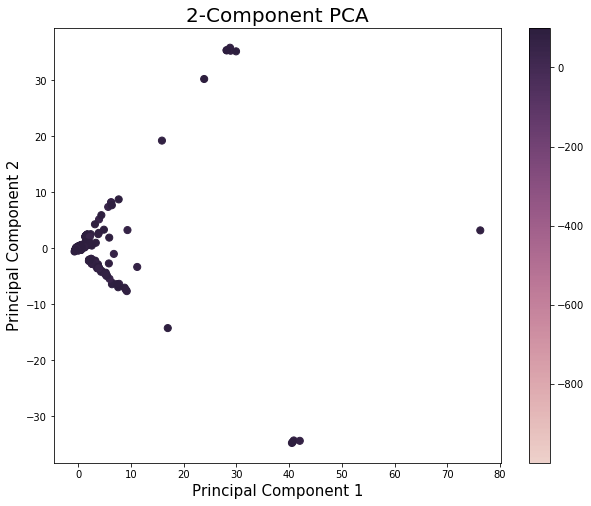

In [73]:
fig, ax = plt.subplots(1, 1, figsize=(10,8))
cmap = sns.cubehelix_palette(as_cmap=True)
pts = ax.scatter(plotdf['pc1'],plotdf['pc2'], c=plotdf['mh_s2'], s=50, cmap=cmap)
fig.colorbar(pts)

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2-Component PCA', fontsize = 20)

In [74]:
pca.explained_variance_ratio_

array([0.17896556, 0.12647151])

### 3.2 Linear Regression

Before performing regression, we should look at a correlation plot to check for collinearity between the features. From the plot below, most of the correlations do look to be about 0, so this is a good sign. Then, I fit the model using scikit-learn's linear regression and checked the output with the model from statsmodels.

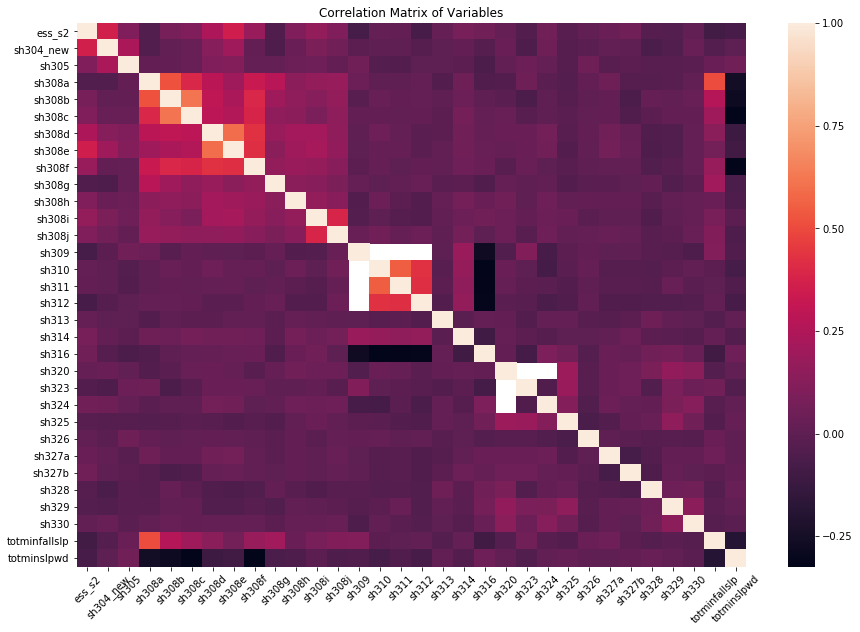

In [75]:
corr_linreg = sleep_vars.corr()
fig, ax = plt.subplots(figsize=(15,10))  
sns.heatmap(corr_linreg, ax=ax)
_ = ax.set_xticklabels(corr_linreg.columns.values,rotation=45)
_ = ax.set_yticklabels(corr_linreg.columns.values,rotation=0)
_ = ax.set_title('Correlation Matrix of Variables')

In [83]:
# split into train/test set
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.1, random_state=0)

In [84]:
# fit model using sklearn
linreg = LinearRegression().fit(Xtrain, ytrain)
print('regression coefficients: ', linreg.coef_)
linreg_preds = linreg.predict(Xtrain)
print('mean squared error:', metrics.mean_squared_error(ytrain, linreg_preds))  
print('root mean squared error:', np.sqrt(metrics.mean_squared_error(ytrain, linreg_preds))) 

regression coefficients:  [ 0.00111873 -0.02942645 -0.00107707  0.03040287  0.02112441  0.013815
  0.01098351  0.01552955  0.00766475  0.00978292 -0.00943449  0.00482058
  0.00871698  0.09849609 -0.00318011  0.00698849 -0.01272809  0.00883796
  0.02622877  0.00680571  0.01027617  0.00413747 -0.00452508  0.06972521
  0.11843299 -0.00561887  0.00731219  0.00052629 -0.00288595  0.09126198
 -0.00781993  0.01240184]
mean squared error: 2864.3262799468134
root mean squared error: 53.51940096775013


In [232]:
print('root mean squared error (positives only):', score(ytrain, linreg_preds)) 

root mean squared error (positives only): 19.21169517072437


In [85]:
# try statsmodels
import statsmodels.api as sm
Xtrain2 = sm.add_constant(Xtrain)
mod = sm.OLS(ytrain,Xtrain2)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  mh_s2   R-squared:                       0.090
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     9.662
Date:                Mon, 08 Oct 2018   Prob (F-statistic):           1.43e-44
Time:                        12:18:48   Log-Likelihood:                -17082.
No. Observations:                3164   AIC:                         3.423e+04
Df Residuals:                    3131   BIC:                         3.443e+04
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            73.0415      3.623     20.162

The models do have the same output, but the adjusted $R^2$ is quite low at 0.081. Additionally, most of the coefficients are statistically insignificant at the 0.05 signifiance level; they have high p-values and the 95% confidence intervals are around zero. This indicates that the features included in this model are likely not to be important in predicting mental health outcomes. The three variables which did have significant coefficients were `sh304_new`, `sh325` and `sh326`.

* `sh304_new`: number of naps per week
    * for example, this coefficient suggests: keeping all other variables constant, an additional nap per week is associated with a 0.0294 decrease in mental health index. This is a tiny change, especially considering the fact that the mental health index generally increases by integer values.
    
* `sh325`: cups of coffee per day
* `sh326`: cups of tea per day

This suggests that caffeine intake and naps taken may be important predictors of mental health.

#### 3.2.1 Linear Regression (with regularization)

I also tried L1 (lasso) and L2 (ridge) regularization to penalize complexity and control for overfitting. Neither of these regularization methods significantly improved the model.

In [94]:
lasso_reg = Lasso(alpha=.1).fit(Xtrain, ytrain)
lasso_preds = lasso_reg.predict(Xtrain)

print('Lasso mean squared error:', metrics.mean_squared_error(ytrain, lasso_preds))  
print('Lasso root mean squared error:', np.sqrt(metrics.mean_squared_error(ytrain, lasso_preds))) 

Lasso mean squared error: 2864.3264174382834
Lasso root mean squared error: 53.51940225225132


In [229]:
print('Lasso root mean squared error (positives only):', score(ytrain, lasso_preds)) 

Lasso root mean squared error (positives only): 19.209809256622755


In [93]:
ridge_reg = Ridge(alpha=.5).fit(Xtrain, ytrain)
ridge_preds = ridge_reg.predict(Xtrain)
print('Ridge mean squared error:', metrics.mean_squared_error(ytrain, ridge_preds))  
print('Ridge root mean squared error:', np.sqrt(metrics.mean_squared_error(ytrain, ridge_preds))) 

Ridge mean squared error: 2864.326279946815
Ridge root mean squared error: 53.519400967750144


In [231]:
print('Ridge root mean squared error (positives only):', score(ytrain, ridge_preds)) 

Ridge root mean squared error (positives only): 19.211694973608765


### 3.3 Random Forest

Switching to a tree-based method, even without any hyperparameter tuning, resulted in a significant improvement from linear regression. The root mean squared error went from 53.519 with regression to 30.954 with random forest.

In [153]:
rf = RandomForestRegressor(random_state = 0)
rf.fit(Xtrain, ytrain)
rf_preds = rf.predict(Xtrain)
print('RF mean squared error:', metrics.mean_squared_error(ytrain, rf_preds))  
print('RF root mean squared error:', np.sqrt(metrics.mean_squared_error(ytrain, rf_preds))) 

RF mean squared error: 958.1419469026549
RF root mean squared error: 30.953868044279297


In [233]:
print('RF root mean squared error (positives only):', score(ytrain, rf_preds)) 

RF root mean squared error (positives only): 15.632696938195604


In [138]:
# tune hyperparameters first by using random search
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 15)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 20)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split}

rf = RandomForestRegressor(random_state=0)
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, 
                               n_iter = 100, cv = 5, verbose=1, random_state=0, n_jobs = -1)
rf_random.fit(Xtrain, ytrain)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 16.5min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 28.9min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 33.2min finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [100, 164, 228, 292, 357, 421, 485, 550, 614, 678, 742, 807, 871, 935, 1000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 15, 20, 25, 31, 36, 41, 46, 52, 57, 62, 67, 73, 78, 83, 88, 94, 99, 104, 110, None], 'min_samples_split': [2, 5, 10]},
          pre_dispatch='2*n_jobs', random_state=0, refit=True,
          return_train_score='warn', scoring=None, verbose=1)

In [139]:
rf_random.best_params_

{'max_depth': 31,
 'max_features': 'sqrt',
 'min_samples_split': 10,
 'n_estimators': 292}

In [142]:
param_grid = {"n_estimators" : [100, 300, 650, 1000],
              "max_depth" : [15, 80, 100],
              "max_features" : ['auto','sqrt'],
              'min_samples_split' : [5, 12, 20]}

rf_cv = RandomForestRegressor(random_state=0)
grid_search = GridSearchCV(estimator = rf_cv, param_grid = param_grid, cv = 5, n_jobs = -1, verbose = 1)
grid_search.fit(Xtrain, ytrain)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed: 17.3min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [100, 300, 650, 1000], 'max_depth': [15, 80, 100], 'max_features': ['auto', 'sqrt'], 'min_samples_split': [5, 12, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [143]:
grid_search.best_params_

{'max_depth': 80,
 'max_features': 'sqrt',
 'min_samples_split': 20,
 'n_estimators': 300}

In [144]:
tuned_rf = RandomForestRegressor(n_estimators = 300, max_depth= 80, max_features='sqrt', min_samples_split= 20, random_state = 0)
tuned_rf.fit(Xtrain, ytrain)
tuned_rf_preds = tuned_rf.predict(Xtrain)
print('RF mean squared error:', metrics.mean_squared_error(ytrain, tuned_rf_preds))  
print('RF root mean squared error:', np.sqrt(metrics.mean_squared_error(ytrain, tuned_rf_preds))) 

RF mean squared error: 2315.943046044799
RF root mean squared error: 48.12424592702517


In [234]:
print('tuned RF root mean squared error (positives only):', score(ytrain, tuned_rf_preds)) 

tuned RF root mean squared error (positives only): 13.641723881791071


In [156]:
#import pickle
#pickle.dump(tuned_rf, open('tuned_rf.pkl', 'wb'))
#pickle.dump(grid_search, open('grid_search.pkl', 'wb'))

##loaded_model = pickle.load(open(filename, 'rb'))

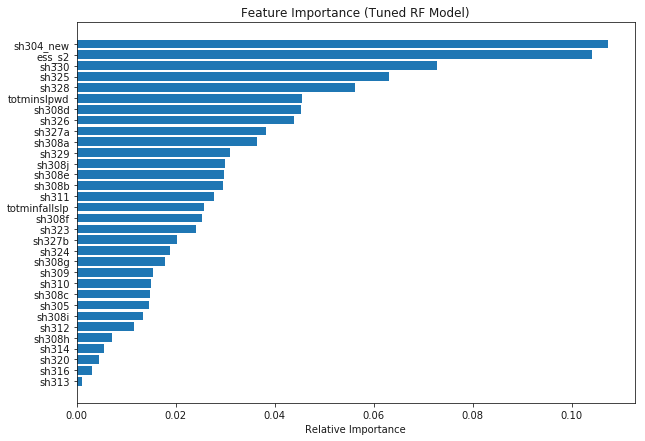

In [349]:
# feature importance
features = Xtrain.columns
importances = tuned_rf.feature_importances_
indices = np.argsort(importances)

sns.set_color_codes("pastel")

plt.figure(figsize=(10,7))
plt.title('Feature Importance (Tuned RF Model)')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### 3.4 XGBoost

The last method attempted is a boosting method: XGBoost. 

In [158]:
xgb = XGBRegressor().fit(Xtrain, ytrain)
xgb_preds = xgb.predict(Xtrain)
print('XGBoost mean squared error:', metrics.mean_squared_error(ytrain, xgb_preds))  
print('XGBoost root mean squared error:', np.sqrt(metrics.mean_squared_error(ytrain, xgb_preds))) 

XGBoost mean squared error: 1318.677274620107
XGBoost root mean squared error: 36.313596277704406


In [235]:
print('XGBoost root mean squared error (positives only):', score(ytrain, xgb_preds)) 

XGBoost root mean squared error (positives only): 14.69072321037885


In [194]:
# tune hyperparameters for xgb
# tree parameters first
xgbparam_grid1 = {'min_child_weight':range(3,10,2),
                 'max_depth': range(3,10,2)}

xgb_cv = XGBRegressor(learning_rate =0.1, random_state=0)
# start with higher learning rate
xgbgrid1 = GridSearchCV(estimator = xgb_cv, param_grid = xgbparam_grid1, cv = 5, 
                        scoring = "neg_mean_squared_error", n_jobs = -1, verbose = 1)
xgbgrid1.fit(Xtrain, ytrain)
xgbgrid1.best_params_

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   31.8s finished


{'max_depth': 3, 'min_child_weight': 9}

In [195]:
xgbparam_grid2 = {'min_child_weight':[8,9,10],
                  'max_depth': [2,3,4]}

xgb_cv = XGBRegressor(learning_rate =0.1, random_state=0)
# start with higher learning rate
xgbgrid2 = GridSearchCV(estimator = xgb_cv, param_grid = xgbparam_grid2, cv = 5, 
                        scoring = "neg_mean_squared_error", n_jobs = -1, verbose = 1)
xgbgrid2.fit(Xtrain, ytrain)
xgbgrid2.best_params_

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   10.6s finished


{'max_depth': 2, 'min_child_weight': 9}

In [196]:
xgbparam_grid3 = {'subsample':[i/10.0 for i in range(6,11)],
                 'colsample_bytree':[i/10.0 for i in range(6,11)]}

xgb_cv = XGBRegressor(learning_rate =0.1, max_depth = 2, min_child_weight=9,random_state=0)
# start with higher learning rate
xgbgrid3 = GridSearchCV(estimator = xgb_cv, param_grid = xgbparam_grid3, cv = 5, 
                        scoring = "neg_mean_squared_error", n_jobs = -1, verbose = 1)
xgbgrid3.fit(Xtrain, ytrain)
xgbgrid3.best_params_

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:   13.6s finished


{'colsample_bytree': 0.6, 'subsample': 0.7}

In [197]:
xgbparam_grid4 = {'subsample':[0.6, 0.7, 0.9],
                 'colsample_bytree':[0.5, 0.6, 0.7, 0.8]}

xgb_cv = XGBRegressor(learning_rate =0.1, max_depth = 2, min_child_weight=9,random_state=0)
# start with higher learning rate
xgbgrid4 = GridSearchCV(estimator = xgb_cv, param_grid = xgbparam_grid4, cv = 5, 
                        scoring = "neg_mean_squared_error", n_jobs = -1, verbose = 1)
xgbgrid4.fit(Xtrain, ytrain)
xgbgrid4.best_params_

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    6.4s finished


{'colsample_bytree': 0.6, 'subsample': 0.7}

In [198]:
# regularization param
xgbparam_grid5 = {'reg_alpha':[0.005, 0.01, 0.1, 1, 100]}

xgb_cv = XGBRegressor(learning_rate =0.1, max_depth = 2, 
                      min_child_weight=9, colsample_bytree = 0.6,
                      subsample = 0.7, random_state=0)
# start with higher learning rate
xgbgrid5 = GridSearchCV(estimator = xgb_cv, param_grid = xgbparam_grid5, cv = 5, 
                        scoring = "neg_mean_squared_error", n_jobs = -1, verbose = 1)
xgbgrid5.fit(Xtrain, ytrain)
xgbgrid5.best_params_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    2.7s finished


{'reg_alpha': 0.01}

In [199]:
# final model
# lower learning rate
tuned_xgb = XGBRegressor(learning_rate =0.01, max_depth = 2, 
                      min_child_weight=9, colsample_bytree = 0.86,
                      subsample = 0.7, reg_alpha = 0.01, random_state=0)
tuned_xgb.fit(Xtrain, ytrain)
tuned_xgb_preds = tuned_xgb.predict(Xtrain)
print('XGB mean squared error:', metrics.mean_squared_error(ytrain, tuned_xgb_preds))  
print('XGB root mean squared error:', np.sqrt(metrics.mean_squared_error(ytrain, tuned_xgb_preds))) 

XGB mean squared error: 3767.261172118049
XGB root mean squared error: 61.378018639558974


In [183]:
#pickle.dump(tuned_xgb, open('grid_search.pkl', 'wb'))

In [236]:
print('tuned XGBoost root mean squared error (positives only):', score(ytrain, tuned_xgb_preds)) 

tuned XGBoost root mean squared error (positives only): 34.33100871599176


### 3.5 Results Summary

As the models were trained, we saw that the tuned Random Forest model had the best training RMSE (when removing the results from the null outcomes). The training RMSE was calculated by calculating the RMSE from the predicted non-null training values and the actual non-null training values. We can get a more reliable estimation of model performance by testing the predictions on a previously unseen test set. Using the 10% of the dataset not used to train the model, the RMSE's are presented in the table below.

In [289]:
# test set results for each model & save predictions
model_list = [lasso_reg, ridge_reg, tuned_rf, tuned_xgb]
test_preds = []
rmses = []

for m in model_list:
    pred = m.predict(Xtest)
    test_preds.append(pred)
    rmse = score(ytest, pred)
    rmses.append(rmse)    

print('RMSE of Models on Test Set (from positive scores only)')
m_names = ['Lasso','Ridge','Random Forest','XGBoost']
pd.DataFrame([rmses],columns=m_names)

RMSE of Models on Test Set (from positive scores only)


,Lasso,Ridge,Random Forest,XGBoost
0,15.522057,15.523522,15.597021,34.492275


From the table of RMSE results, we can see that the Lasso and Ridge Regression models performed the best. Surprisingly, XGBoost performs the worst. This could be due to the large amount of missing data. The tree-based models could have been overfitting to our dataset, which had a lot of noise and a lot of negative values from the missing data.

In [294]:
# plot index vs predicted values (positives)
orig_test = np.array(list(ytest))
#pred = np.array(list(pred_y))
# set negatives = -1
ix = np.where(orig_test < 0)
orig_test[ix] = -1
test_preds_new = test_preds

for i in test_preds_new:
    i[ix] = -1

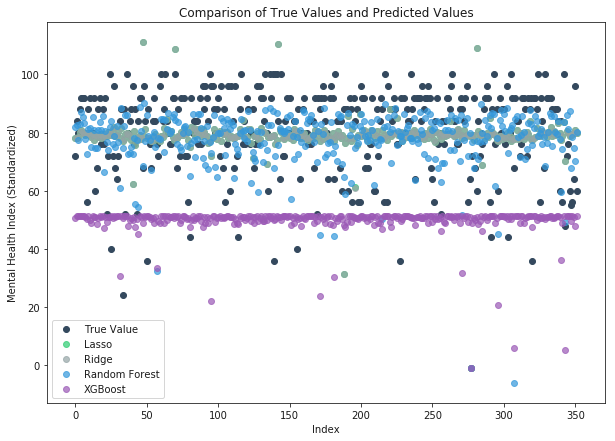

In [363]:
flatui = ["#95a5a6", "#3498db", "#9b59b6", "#e74c3c", "#34495e", "#2ecc71"]

plt.figure(figsize=(10,7))
plt.title('Comparison of True Values and Predicted Values')
plt.scatter(range(len(orig_test)), orig_test, color = flatui[4], label = 'True Value')
for n,m in enumerate(test_preds_new):
    plt.scatter(range(len(m)), m, color = flatui[n-1], label = m_names[n],alpha=.7)
plt.xlabel('Index')
plt.ylabel('Mental Health Index (Standardized)')
plt.legend()
plt.show()

From the plot of the true mental health indices to the predicted values from each model, we can see that XGBoost consistently predicted an index around 50, explaining the poor RMSE. The Ridge and Lasso predictions had almost the same predictions. Like XGBoost, it tended to predict around the same value - in this case, it averaged about 80 which was closer to the true average. The Random Forest model seemed to mimic the distribution of the data a little better than the other models, with the predictions having greater variance as the original data did.

Since we know that the regression and random forest models performed, the best, our interpretations from those models should be reliable.

The three significant features from the linear regression model were:

* `sh304_new`: number of naps per week
* `sh325`: cups of coffee per day
* `sh326`: cups of tea per day

From the random forest model, the top five most important features of the model were:

* `sh304_new`: number of naps per week
* `ess_s2`: Epworth Sleepiness Scale (ESS) score 
* `sh330`: drinks of hard liquor per week
* `sh325`: cups of coffee per day
* `sh328`: glasses of wine per week

The number of naps taken per week and the cups of coffee consumed per day were both deemed important in influencing an individuals' mental health score, in this cohort. Alcohol and caffeine intake could be related to both sleep habits and mental health, so they could be confounders in this case. It is also interesting to note that the ESS score was an important feature in predicting the mental health index. While this tells us nothing about whether it positively or negatively impacts the mental health index, this could be something to look into in the future.

## 4. Discussion

The results of this analysis give us justification for further feature selection to minimize the noise in this dataset and/or more advanced methods of modeling the mental health index to determine causal relationships. None of the models used in this analysis could determine a direct causal relationship between one's self-reported sleep habits and their mental health. 

This project was also limited due to the selection of the outcome variable, the SF-36's Mental Health Index Standardized Score. In retrospect, it may have been an easier problem to turn this into a classification problem and model whether an individual would have higher or lower than average mental health index. It is also possible that this was not the best measure to use, and other mental health related questions would have been more relevant. The authors of the SF-36 questionnaire also stated that questions left blank on the questionnaire are not taken into account when calculating the scores, meaning the outcomes could also be biased [6].

Additionally, there was a lot of missing data included in the analysis. Though I chose to replace all the null values with -999, this caused issues when predicting a continuous outcome because the model was trained on many "null" outcomes. The "null" predictions could also range anywhere from -999 to 0, with no sense of where the individual would actually fall on the mental health score scale. In future analyses, it may be helpful to impute those missing values. 

## References

[1] Dean DA 2nd, Goldberger AL, Mueller R, Kim M, Rueschman M, Mobley D, Sahoo SS, Jayapandian CP, Cui L, Morrical MG, Surovec S, Zhang GQ, Redline S. Scaling Up Scientific Discovery in Sleep Medicine: The National Sleep Research Resource. Sleep. 2016 May 1;39(5):1151-64. doi: 10.5665/sleep.5774. Review. PubMed PMID: 27070134; PubMed Central PMCID: PMC4835314.

[2] Zhang GQ, Cui L, Mueller R, Tao S, Kim M, Rueschman M, Mariani S, Mobley D, Redline S. The National Sleep Research Resource: towards a sleep data commons. J Am Med Inform Assoc. 2018 May 31. doi: 10.1093/jamia/ocy064. [Epub ahead of print] PubMed PMID: 29860441.

[3] Quan SF, Howard BV, Iber C, Kiley JP, Nieto FJ, O'Connor GT, Rapoport DM, Redline S, Robbins J, Samet JM, Wahl PW. The Sleep Heart Health Study: design, rationale, and methods. Sleep. 1997 Dec;20(12):1077-85. PubMed PMID: 9493915.

[4] Redline S, Sanders MH, Lind BK, Quan SF, Iber C, Gottlieb DJ, Bonekat WH, Rapoport DM, Smith PL, Kiley JP. Methods for obtaining and analyzing unattended polysomnography data for a multicenter study. Sleep Heart Health Research Group. Sleep. 1998 Nov 1;21(7):759-67. PubMed PMID: 11300121.

[5] Johns MW. A new method for measuring daytime sleepiness: the [Epworth Sleepiness Scale](http://epworthsleepinessscale.com/). Sleep 1991;14:540–5. 

[6] 36-Item Short Form Survey (SF-36) Scoring Instructions. RAND Corporation; [accessed 2018 Oct 8]. https://www.rand.org/health/surveys_tools/mos/36-item-short-form/scoring.html.

[7] Mental Illness - Symptoms and Causes. c1998-2018. Mayo Clinic; [accessed 2018 Oct 8]. https://www.mayoclinic.org/diseases-conditions/mental-illness/symptoms-causes/syc-20374968.